In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import math
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [3]:
path_base = '../data/Borcherding/'
path_merged = path_base + '01_borch_merged.h5ad'
path_filtered = path_base + '02_borch_filtered_tcr.h5ad'
path_highlyvar = path_base + '03_borch_highly_var.h5ad'
path_annotated = path_base + '04_borch_annotated.h5ad'

## Merge Files

The dataset of Borcherding contains 1.5 million cells from various joint scRNA and VDJ studies. To convert the dataset to python format refer to the notebook "RDS_2_AnnData.ipynb". In the following they are processed to scanpy / scirpy format.

In [4]:
# Transcriptome data
file_name = path_base + 'rna_combined.h5ad'
adata = sc.read(file_name)

In [5]:
# TCR data
path_anno = path_base + 'tcrs_combined.csv'
anno_tcr = pd.read_csv(path_anno,index_col=0)  
anno_tcr = anno_tcr.set_index('barcode')

for col in ['IR_VJ_2_cdr3', 'IR_VDJ_2_cdr3', 'IR_VDJ_2_c_gene', 'IR_VDJ_2_junction_ins', 'IR_VDJ_2_v_gene',
            'IR_VDJ_2_expr', 'IR_VJ_2_d_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_2_v_gene', 'IR_VJ_2_j_gene', 
            'IR_VJ_2_expr', 'IR_VDJ_2_locus', 'IR_VJ_2_junction_ins', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_2_expr_raw',
            'IR_VDJ_2_expr_raw', 'IR_VJ_2_c_gene', 'IR_VDJ_2_d_gene', 'IR_VDJ_2_cdr3', 'IR_VJ_2_cdr3_nt' 
            'IR_VDJ_1_d_gene', 'IR_VJ_1_junction_ins', 'IR_VDJ_1_expr', 'IR_VJ_1_d_gene', 'IR_VJ_1_expr_raw', 
            'IR_VJ_1_expr', 'IR_VDJ_1_expr_raw', 'IR_VDJ_1_junction_ins', 'IR_VDJ_1_d_gene', 'IR_VJ_2_cdr3_nt']:
    anno_tcr[col] = None

rename_dict = {
#    'TCR1': ,
    'cdr3_aa1': 'IR_VJ_1_cdr3',
    'cdr3_nt1': 'IR_VJ_1_cdr3_nt',
#    'TCR2': ,
    'cdr3_aa2': 'IR_VDJ_1_cdr3', 
    'cdr3_nt2': 'IR_VDJ_1_cdr3_nt',
}
anno_tcr = anno_tcr.rename(rename_dict, axis=1)
anno_tcr['IR_VJ_1_locus'] = 'TRA'
anno_tcr['IR_VJ_2_locus'] = 'TRA'
anno_tcr['IR_VDJ_1_locus'] = 'TRB'
anno_tcr['IR_VDJ_2_locus'] = 'TRB'

anno_tcr['IR_VJ_1_v_gene'] = [el.split('.')[0] if isinstance(el, str) else None for el in anno_tcr['TCR1']]
anno_tcr['IR_VJ_1_c_gene'] = [el.split('.')[2] if isinstance(el, str) else None for el in anno_tcr['TCR1']]
anno_tcr['IR_VJ_1_j_gene'] = [el.split('.')[1] if isinstance(el, str) else None for el in anno_tcr['TCR1']]

anno_tcr['IR_VDJ_1_v_gene'] = [el.split('.')[0] if isinstance(el, str) else None for el in anno_tcr['TCR2']]
anno_tcr['IR_VDJ_1_c_gene'] = [el.split('.')[3] if isinstance(el, str) else None for el in anno_tcr['TCR2']]
anno_tcr['IR_VDJ_1_j_gene'] = [el.split('.')[2] if isinstance(el, str) else None for el in anno_tcr['TCR2']]


anno_tcr['multi_chain'] = False
anno_tcr['has_ir'] = ~anno_tcr['IR_VJ_1_cdr3'].isnull() | ~anno_tcr['IR_VDJ_1_cdr3'].isnull()

anno_tcr.index.name = None
anno_tcr = ann.AnnData(obs=anno_tcr)
anno_tcr.obs_names_make_unique()
anno_tcr

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 1213262 × 0
    obs: 'sample', 'ID', 'TCR1', 'IR_VJ_1_cdr3', 'IR_VJ_1_cdr3_nt', 'TCR2', 'IR_VDJ_1_cdr3', 'IR_VDJ_1_cdr3_nt', 'CTgene', 'CTnt', 'CTaa', 'CTstrict', 'cellType', 'Patient', 'IR_VJ_2_cdr3', 'IR_VDJ_2_cdr3', 'IR_VDJ_2_c_gene', 'IR_VDJ_2_junction_ins', 'IR_VDJ_2_v_gene', 'IR_VDJ_2_expr', 'IR_VJ_2_d_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_2_v_gene', 'IR_VJ_2_j_gene', 'IR_VJ_2_expr', 'IR_VDJ_2_locus', 'IR_VJ_2_junction_ins', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_2_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_2_c_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_2_cdr3_ntIR_VDJ_1_d_gene', 'IR_VJ_1_junction_ins', 'IR_VDJ_1_expr', 'IR_VJ_1_d_gene', 'IR_VJ_1_expr_raw', 'IR_VJ_1_expr', 'IR_VDJ_1_expr_raw', 'IR_VDJ_1_junction_ins', 'IR_VDJ_1_d_gene', 'IR_VJ_2_cdr3_nt', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VJ_1_v_gene', 'IR_VJ_1_c_gene', 'IR_VJ_1_j_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_1_j_gene', 'multi_chain', 'has_ir'

In [6]:
ir.pp.merge_with_ir(adata, anno_tcr)
sc.write(adata=adata, filename=path_merged)

... storing 'sample' as categorical
... storing 'ID' as categorical
... storing 'TCR1' as categorical
... storing 'TCR2' as categorical
... storing 'CTgene_y' as categorical
... storing 'CTnt_y' as categorical
... storing 'CTaa_y' as categorical
... storing 'CTstrict_y' as categorical
... storing 'cellType' as categorical
... storing 'Patient' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_expr' as categorical
... storing 'IR_VJ_2_expr' as categorical
... storing 'IR_VDJ_1_expr' as categorical
... storing 'IR_VDJ_2_expr' as categorical
... storing 'IR_VJ_1_expr_raw' as categorical
... storing 'IR_VJ_2_expr_raw' as categorical
... storing 'IR_VDJ_1_exp

In [7]:
count_irs = sum([1 for x in adata.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata)}')
print(f'With IR-Info: {count_irs}')

Total Count: 1593679
With IR-Info: 1080285


In [8]:
adata.obs['Tissue'].value_counts()

Lung           959223
Renal          216243
Esophagus      107508
Melanoma        85889
HNSCC           52914
BCC             52294
Endometrial     33405
Breast          27651
Ovarian         26760
SCC             25740
Colorectal       6052
Name: Tissue, dtype: int64

In [9]:
adata.obs['Type'].value_counts()

Tumor     891316
Blood     273319
Normal    267657
LN        125615
Met        32011
Juxta       3761
Name: Type, dtype: int64

# Qualitiy control

Filter out cells without alpha and beta chain

In [10]:
adata = sc.read(path_merged)

In [11]:
print(f'Total cells: {len(adata)}')
adata = adata[adata.obs['has_ir']=='True']
print(f'With IR: {len(adata)}')
adata = adata[adata.obs['IR_VDJ_1_cdr3']!='nan']
print(f'With beta chain: {len(adata)}')
adata = adata[adata.obs['IR_VJ_1_cdr3']!='nan']
print(f'With alpha chain: {len(adata)}')
adata = adata[~adata.obs['IR_VJ_1_cdr3'].str.contains(';')]
print(f'Without dual alpha chains: {len(adata)}')
adata = adata[~adata.obs['IR_VDJ_1_cdr3'].str.contains(';')]
print(f'Without dual beta chains: {len(adata)}')

Total cells: 1593679
With IR: 1080285
With beta chain: 1046539
With alpha chain: 795768
Without dual alpha chains: 795738
Without dual beta chains: 795732


In [12]:
adata = adata[adata.obs['db.class']=='singlet']
print(f'Without doublets: {len(adata)}')

Without doublets: 722461


In [13]:
sc.pp.filter_genes(adata, min_cells=100)
print(f'Number of cells after gene filter: {adata.n_vars}')

filtered out 37683 genes that are detected in less than 100 cells
Trying to set attribute `.var` of view, copying.


Number of cells after gene filter: 21643


Load data and calculate the amount of counts, genes and fraction of mitochondrial genes.

In [14]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

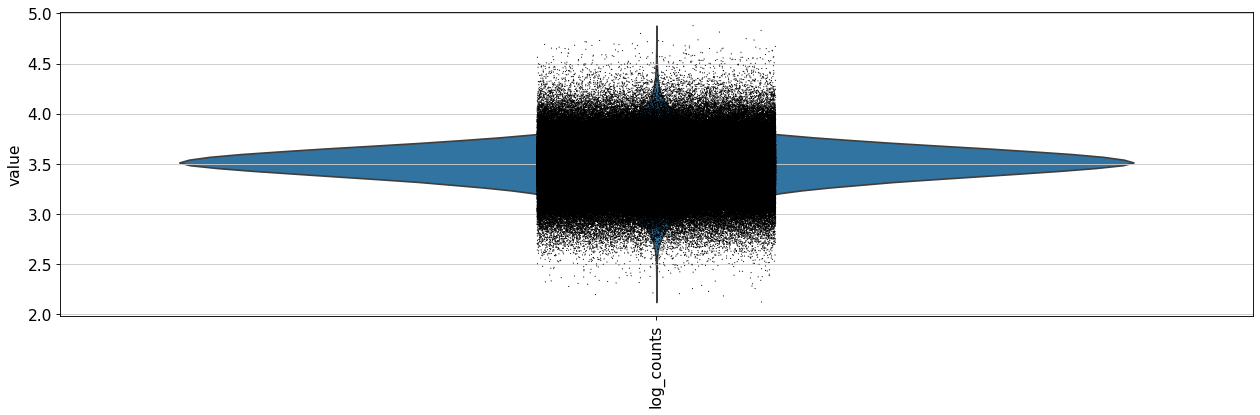

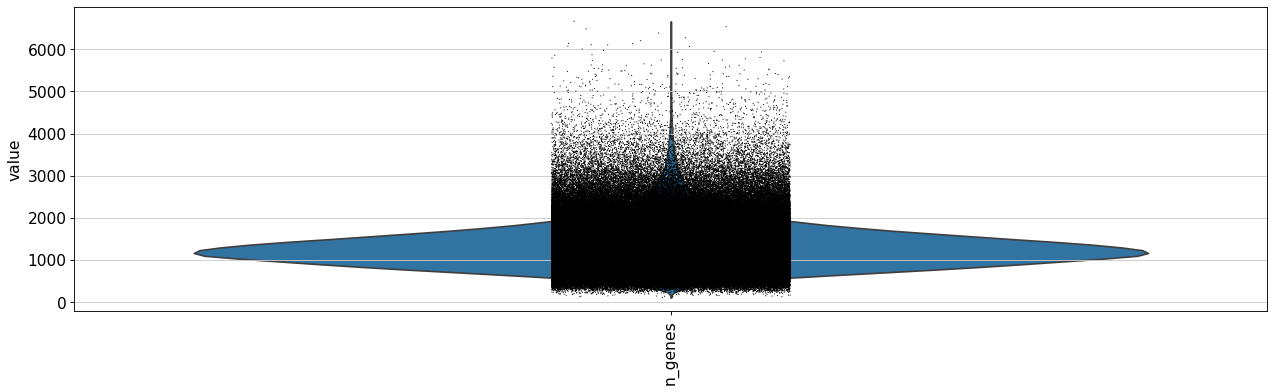

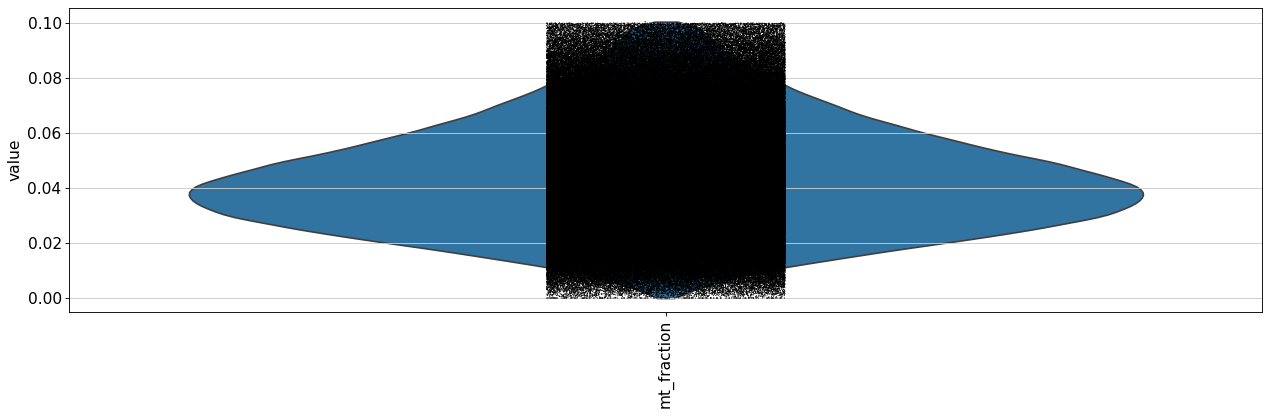

In [15]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], size=1, log=False, rotation=90)

<Axes:title={'center':'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

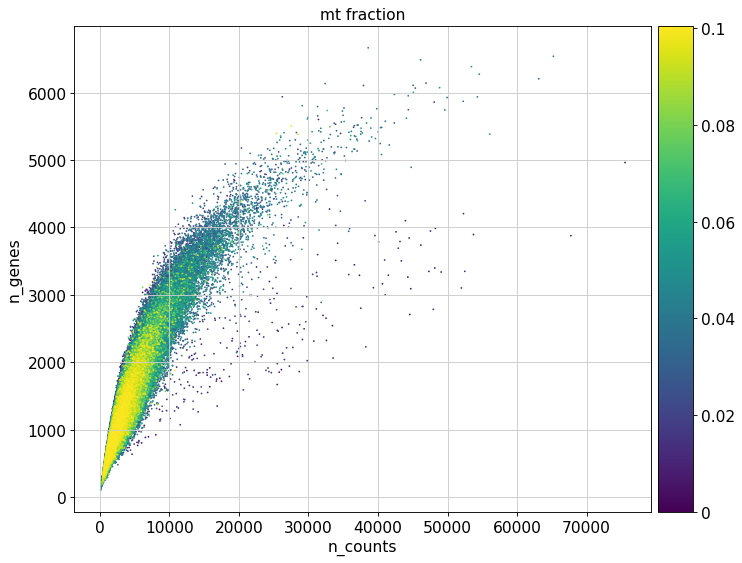

In [16]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes:title={'center':'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

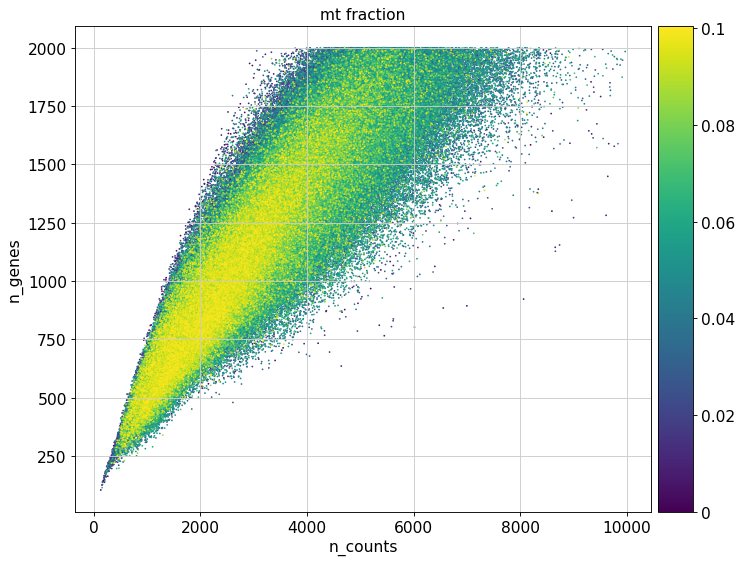

In [17]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

In [18]:
sc.write(adata=adata, filename=path_filtered)

## Normalization and highly variable gene selection


In [19]:
adata = sc.read(path_filtered)

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:07)


In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
print('Shape before: ', adata.shape)
adata = adata[:, adata.var['highly_variable']]
print('Shape after: ', adata.shape)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:35)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Shape before:  (722461, 21643)
Shape after:  (722461, 5000)


In [22]:
sc.write(adata=adata, filename=path_highlyvar)

## Model Specific Preproccessing


In [23]:
adata = sc.read(path_highlyvar)

### Clonotype annotation

The clonotype annotation from 10x defines clonotypes not accross all donors. Therefor, public TCRs might leak between training and testing data. Further, cells with the same TCR but multiple IRs are classified as different clonotypes. We therefor assign own clonotype labels based on complete correspondence based on alpha and beta chain.

In [24]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_cdr3'].astype(str) + '+' + adata.obs['IR_VDJ_1_cdr3'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

302947


BT1.1_AAACCTGAGCAGACTG-1    0
BT1.1_AAACCTGAGGTCGGAT-1    1
BT1.1_AAACCTGAGTGTACCT-1    2
BT1.1_AAACCTGAGTGTACTC-1    3
BT1.1_AAACCTGCAACACCCG-1    4
Name: clonotype, dtype: int64

### Embed Proteins

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [25]:
import sys
sys.path.append('../')
import tcr_embedding.utils_preprocessing as utils

In [26]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}

utils.aa_encoding(adata, read_col='IR_VJ_1_cdr3', label_col='alpha_seq', length_col='alpha_len', pad=30, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='IR_VDJ_1_cdr3', label_col='beta_seq', length_col='beta_len', pad=40, aa_to_id=aa_to_id, start_end_symbol=False)

In [27]:
adata.obsm['beta_seq']

array([[ 2,  1, 17, ...,  0,  0,  0],
       [ 2,  1, 16, ...,  0,  0,  0],
       [ 2,  1, 16, ...,  0,  0,  0],
       ...,
       [ 2, 16, 18, ...,  0,  0,  0],
       [ 2, 16,  1, ...,  0,  0,  0],
       [ 2,  1, 16, ...,  0,  0,  0]])

In [28]:
adata.write_h5ad(path_annotated)

... storing 'TRA+TRB' as categorical
